In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Đường dẫn file zip trên Google Drive
train_zip_path = '/content/drive/MyDrive/train.zip'
test_zip_path = '/content/drive/MyDrive/test1.zip'

# Tạo folder chứa data sau khi giải nén
os.makedirs('/content/data/train', exist_ok=True)
os.makedirs('/content/data/test', exist_ok=True)

# Giải nén train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data/train')

# Giải nén test1.zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data/test')
# Kiểm tra dữ liệu
print("Số file train:", len(os.listdir('/content/data/train/train')))
print("Số file test:", len(os.listdir('/content/data/test/test1')))


Số file train: 25000
Số file test: 12500


In [ ]:
# ==============================================
# CHUẨN BỊ THƯ MỤC TRAIN/VALIDATION
# ==============================================

import shutil
from sklearn.model_selection import train_test_split

train_folder = '/content/data/cats_vs_dogs/train'
val_folder = '/content/data/cats_vs_dogs/val'

# Tạo thư mục mới
os.makedirs(train_folder + '/cats', exist_ok=True)
os.makedirs(train_folder + '/dogs', exist_ok=True)
os.makedirs(val_folder + '/cats', exist_ok=True)
os.makedirs(val_folder + '/dogs', exist_ok=True)

# Lấy danh sách file
img_dir = '/content/data/train/train'
files = os.listdir(img_dir)

# Phân loại theo tên file (cat = 0, dog = 1)
cats = [f for f in files if f.startswith('cat')]
dogs = [f for f in files if f.startswith('dog')]

# Chia train/val (80/20)
train_cats, val_cats = train_test_split(cats, test_size=0.2, random_state=42)
train_dogs, val_dogs = train_test_split(dogs, test_size=0.2, random_state=42)

# Di chuyển file
for f in train_cats:
    shutil.move(os.path.join(img_dir, f), os.path.join(train_folder, 'cats', f))

for f in val_cats:
    shutil.move(os.path.join(img_dir, f), os.path.join(val_folder, 'cats', f))

for f in train_dogs:
    shutil.move(os.path.join(img_dir, f), os.path.join(train_folder, 'dogs', f))

for f in val_dogs:
    shutil.move(os.path.join(img_dir, f), os.path.join(val_folder, 'dogs', f))

print("Số ảnh train - Cats:", len(os.listdir(train_folder + '/cats')))
print("Số ảnh train - Dogs:", len(os.listdir(train_folder + '/dogs')))
print("Số ảnh val - Cats:", len(os.listdir(val_folder + '/cats')))
print("Số ảnh val - Dogs:", len(os.listdir(val_folder + '/dogs')))


Số ảnh train - Cats: 10000
Số ảnh train - Dogs: 10000
Số ảnh val - Cats: 2500
Số ảnh val - Dogs: 2500


In [ ]:
import tensorflow as tf

IMAGE_SIZE = (160, 160)  # Sửa IMAGE_SIZE thành tuple (160, 160)
BATCH_SIZE = 16

# Định nghĩa lại train_folder và val_folder trong cell này
train_folder = '/content/data/cats_vs_dogs/train'
val_folder = '/content/data/cats_vs_dogs/val'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Remove the extra .batch call and apply prefetch directly
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE) # Remove extra .batch(BATCH_SIZE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE) # Remove extra .batch(BATCH_SIZE)


print("✅ Đã load xong dataset!")

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
✅ Đã load xong dataset!


In [ ]:
# ==============================================
#  XÂY DỰNG MODEL - FINE TUNE MobileNetV2
# ==============================================

import tensorflow as tf

# Tạo lớp data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

# Load MobileNetV2 với weights 'imagenet'
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Cho phép fine-tune
base_model.trainable = True

# Chỉ fine-tune 50 layers cuối cùng
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Tạo mô hình hoàn chỉnh
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),  # Scale ảnh từ 0-255 về 0-1
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),    # Thêm Dense
    tf.keras.layers.Dropout(0.5),                     # Giảm overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')    # Output binary (dog/cat)
])

# Compile model với learning rate nhỏ hơn để fine-tune
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

print("✅ Đã xây dựng xong model!")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

✅ Đã xây dựng xong model!


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train với toàn bộ tập dữ liệu
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stop, reduce_lr, checkpoint_cb])
# Lưu mô hình full đã huấn luyện
model.save('/content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/dogvscat_model.h5')

Epoch 1/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7426 - loss: 0.5038
Epoch 1: val_loss improved from inf to 0.07208, saving model to /content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 109s 51ms/step - accuracy: 0.7428 - loss: 0.5036 - val_accuracy: 0.9748 - val_loss: 0.0721 - learning_rate: 1.0000e-05
Epoch 2/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9019 - loss: 0.2294
Epoch 2: val_loss improved from 0.07208 to 0.06467, saving model to /content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 40ms/step - accuracy: 0.9019 - loss: 0.2294 - val_accuracy: 0.9768 - val_loss: 0.0647 - learning_rate: 1.0000e-05
Epoch 3/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9176 - loss: 0.2008
Epoch 3: val_loss improved from 0.06467 to 0.05887, saving model to /content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9176 - loss: 0.2008 - val_accuracy: 0.9788 - val_loss: 0.0589 - learning_rate: 1.0000e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9266 - loss: 0.1732
Epoch 4: val_loss improved from 0.05887 to 0.05500, saving model to /content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.9266 - loss: 0.1732 - val_accuracy: 0.9814 - val_loss: 0.0550 - learning_rate: 1.0000e-05
Epoch 5/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9338 - loss: 0.1612
Epoch 5: val_loss did not improve from 0.05500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9338 - loss: 0.1612 - val_accuracy: 0.9814 - val_loss: 0.0555 - learning_rate: 1.0000e-05
Epoch 6/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9413 - loss: 0.1428
Epoch 6: val_loss improved from 0.05500 to 0.05192, saving model to /content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9413 - loss: 0.1428 - val_accuracy: 0.9828 - val_loss: 0.0519 - learning_rate: 1.0000e-05
Epoch 7/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9480 - loss: 0.1277
Epoch 7: val_loss improved from 0.05192 to 0.04836, saving model to /content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/best_model.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9480 - loss: 0.1278 - val_accuracy: 0.9834 - val_loss: 0.0484 - learning_rate: 1.0000e-05
Epoch 8/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9524 - loss: 0.1227
Epoch 8: val_loss did not improve from 0.04836
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - accuracy: 0.9524 - loss: 0.1227 - val_accuracy: 0.9762 - val_loss: 0.0634 - learning_rate: 1.0000e-05
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9538 - loss: 0.1167
Epoch 9: val_loss did not improve from 0.04836
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9538 - loss: 0.1167 - val_accuracy: 0.9812 - val_loss: 0.0509 - learning_rate: 1.0000e-05
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9559 - loss: 0.1101
Epoch 10: val_loss did not improve from 0.04836
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9559 - loss: 0.1101 - val_accuracy: 0.9812 - val_loss: 0.0527 - learning_rate: 2.000

<ipython-input-8-9f447ddd7362>:45: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


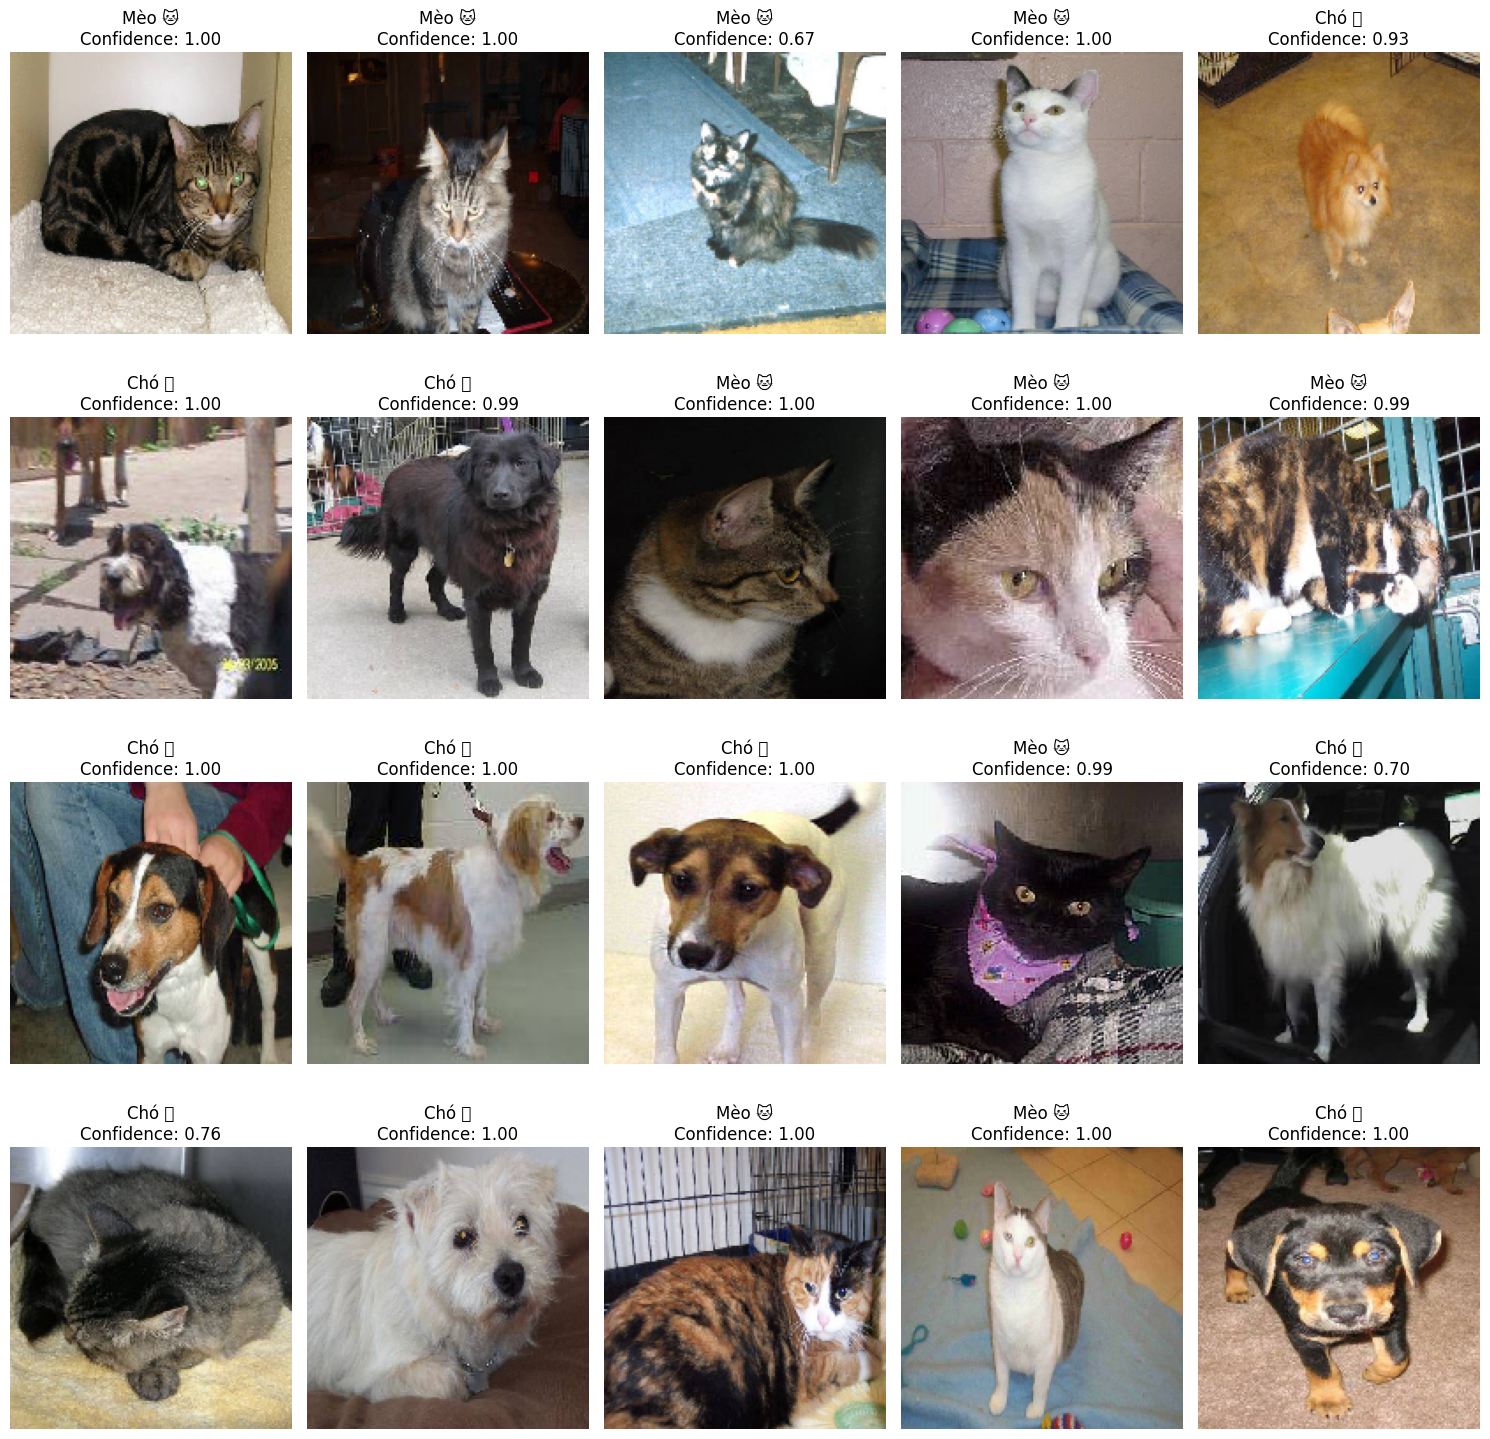

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model đã train
model_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning/DogvsCat/dogvscat_model.h5'
model = load_model(model_path)

# Đường dẫn folder test
test_folder = '/content/data/test/test1'

# Lấy tất cả file ảnh test
test_image_files = os.listdir(test_folder)

# Test 20 ảnh đầu tiên
sample_files = test_image_files[:20]

# Kích thước ảnh phải khớp với model input
IMAGE_SIZE = (160, 160)

# Hàm predict và hiển thị ảnh
def predict_and_show_images(model, image_files, folder_path, image_size=IMAGE_SIZE):
    plt.figure(figsize=(15, 15))

    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)

        img = image.load_img(img_path, target_size=image_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        #img_array = img_array / 255.0  # Chuẩn hóa

        prediction = model.predict(img_array, verbose=0)
        pred_label = 'Chó 🐶' if prediction[0][0] >= 0.5 else 'Mèo 🐱'
        confidence = prediction[0][0] if prediction[0][0] >= 0.5 else 1 - prediction[0][0]

        plt.subplot(4, 5, idx + 1)
        plt.imshow(img)
        plt.title(f'{pred_label}\nConfidence: {confidence:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Chạy test model
predict_and_show_images(model, sample_files, test_folder, image_size=IMAGE_SIZE)


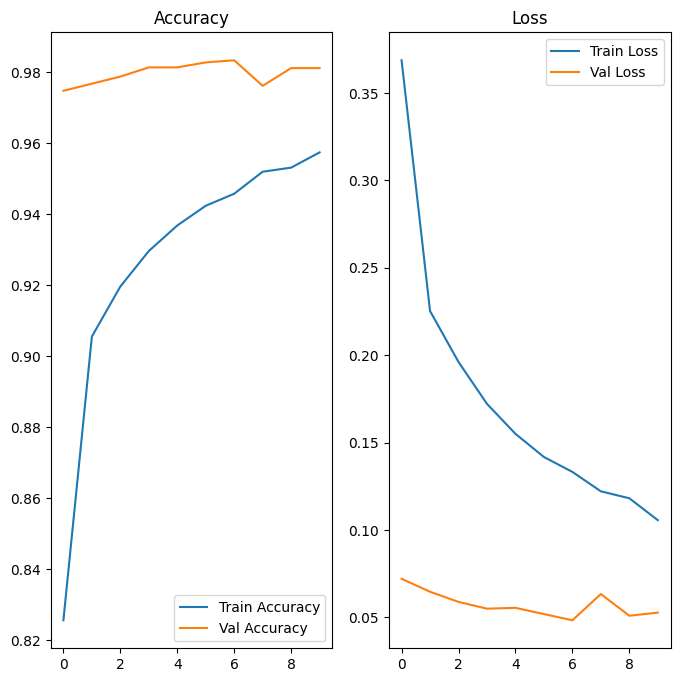

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()
